In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('airline-passenger-traffic.csv', header=None)
df.columns = ['Month','Passengers']
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df = df.set_index('Month')
df

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


### Plotting time series data

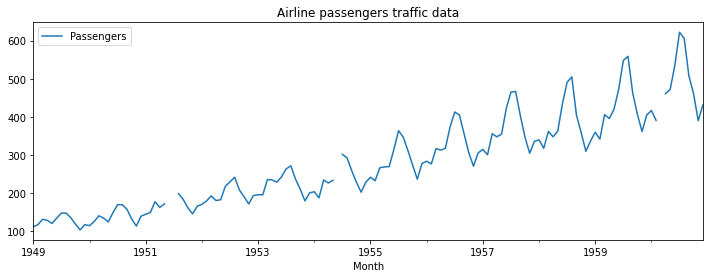

In [31]:
df.plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline passengers traffic data')
plt.show(block=False)

### handling missing values

#### mean imputation

In [32]:
df.Passengers.mean()

280.73571428571427

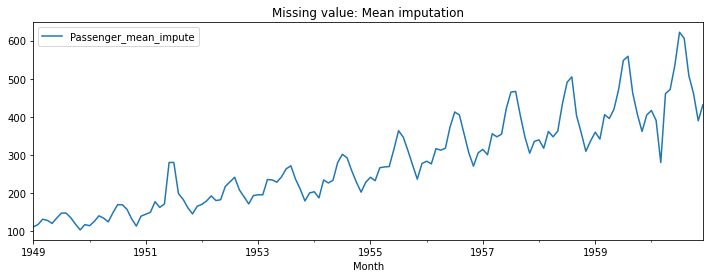

In [33]:
df = df.assign(Passenger_mean_impute = df.Passengers.fillna(df.Passengers.mean()))
df[['Passenger_mean_impute']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Mean imputation')
plt.show(block=False)

#### Linear interpolation

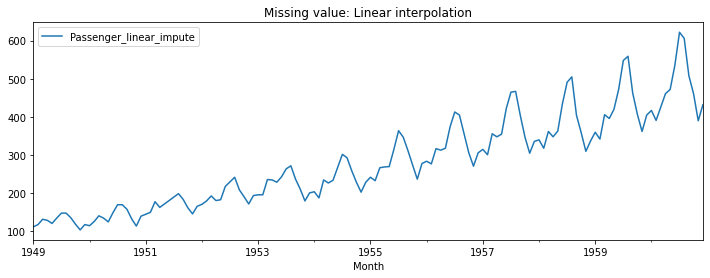

In [3]:
df = df.assign(Passenger_linear_impute = df.Passengers.interpolate(method='linear'))
df[['Passenger_linear_impute']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Linear interpolation')
plt.show(block=False)

#### Using linear interpolation for missing values 

In [4]:
df['Passengers'] = df['Passenger_linear_impute']

In [36]:
df.Passenger_linear_impute.isnull().sum()

0

### Outlier treatment

#### Boxplot and IQR

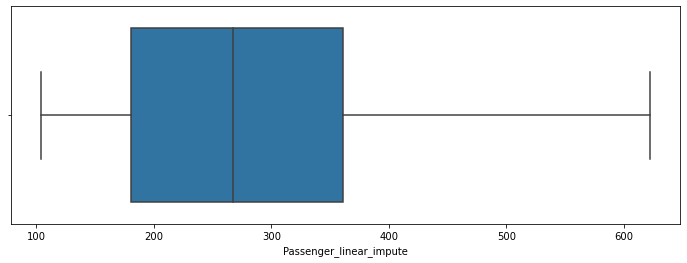

In [37]:
fig = plt.subplots(figsize=(12,4))
ax = sns.boxplot(x=df['Passenger_linear_impute'], whis=1.5)
# ax = sns.boxplot(x=df['Passenger_linear_impute'], whis=1)
# ax = sns.boxplot(x=df['Passenger_linear_impute'])

#### Histogram plot

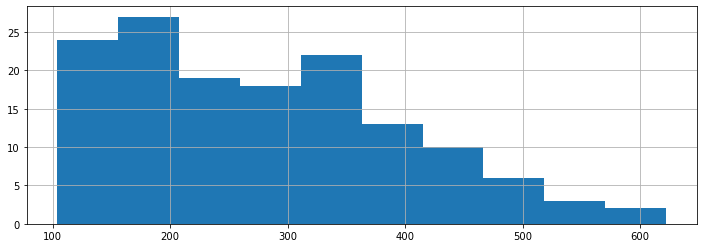

In [38]:
fig = df['Passenger_linear_impute'].hist(figsize=(12,4))

#### These methods show we do not have any outliers

### Time series decomposition

#### Additive seasonal decomposition

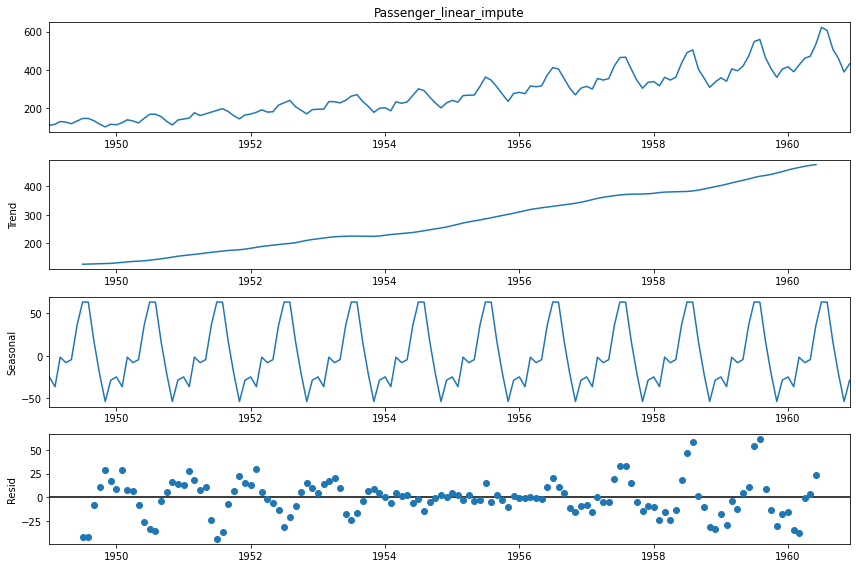

In [39]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(df['Passenger_linear_impute'], model='additive') #tsa = time series analysis
fig = decomposition.plot()
plt.show()

#### Multiplicative seasonal decomposition

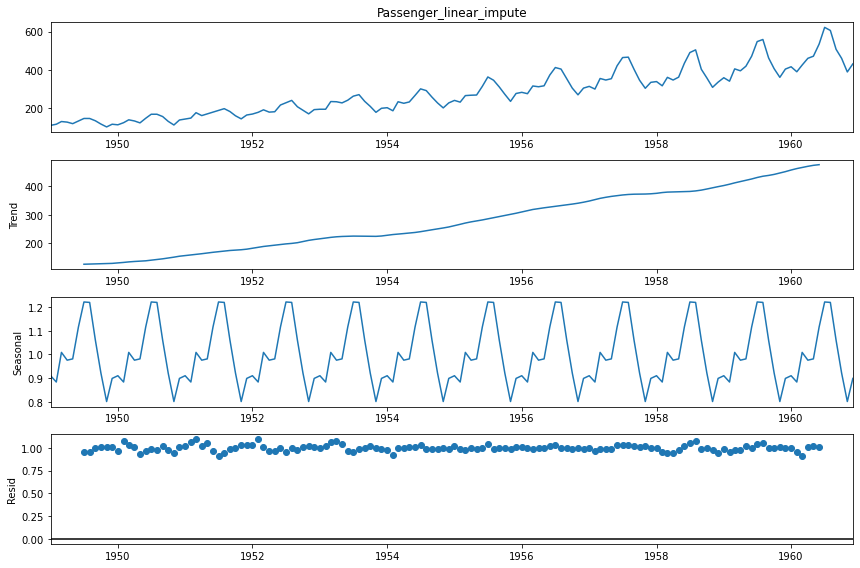

In [40]:
decomposition = sm.tsa.seasonal_decompose(df['Passenger_linear_impute'], model='multiplicative')
fig = decomposition.plot()
plt.show()

### Build and evalueate time series forecast

#### Splitting time series data into train and test sets

In [5]:
train_len = 120
train = df[0:train_len]
test = df[train_len:]

#### Naive method

In [42]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passenger_linear_impute'][train_len-1] #train_len-1 is the last observation in train data

#### Plot train, test and forecast

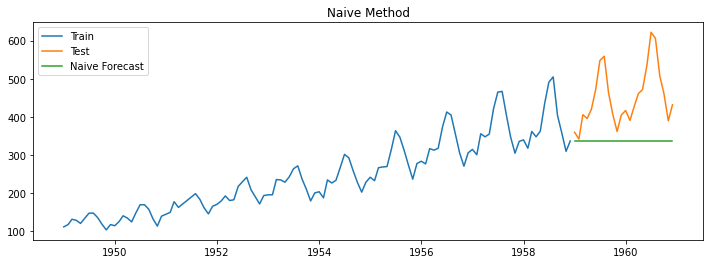

In [43]:
plt.figure(figsize=(12,4))
plt.plot(train['Passenger_linear_impute'], label = 'Train')
plt.plot(test['Passenger_linear_impute'], label = 'Test')
plt.plot(y_hat_naive['naive_forecast'], label = 'Naive Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Naive Method')
plt.show()

#### Simple average method

In [44]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passenger_linear_impute'].mean()

#### Plot train, test and forecast

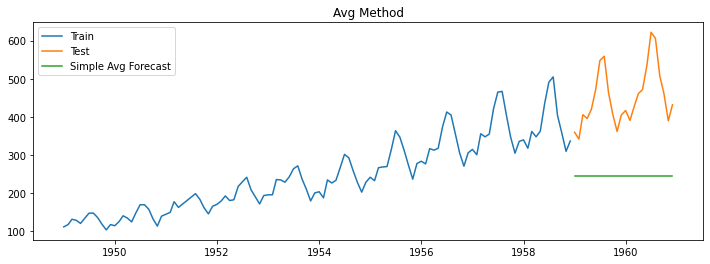

In [45]:
plt.figure(figsize=(12,4))
plt.plot(train['Passenger_linear_impute'], label = 'Train')
plt.plot(test['Passenger_linear_impute'], label = 'Test')
plt.plot(y_hat_avg['avg_forecast'], label = 'Simple Avg Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Avg Method')
plt.show()

#### Calculate RMSE and MAPE to evaluate naive forecast

In [46]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passenger_linear_impute'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passenger_linear_impute'] - y_hat_naive['naive_forecast'])/test['Passenger_linear_impute'])*100,2)
#Mape is in percentage
results = pd.DataFrame({'Method' : ['Naive method'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = results[['Method', 'MAPE', 'RMSE']]
results
#Mape 23.63 implies model is 76.37% accurate

,Method,MAPE,RMSE
0,Naive method,23.63,137.51


#### Calculate RMSE and MAPE to evaluate avg forecast

In [47]:
rmse = np.sqrt(mean_squared_error(test['Passenger_linear_impute'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passenger_linear_impute'] - y_hat_avg['avg_forecast'])/test['Passenger_linear_impute'])*100,2)
tempResults = pd.DataFrame({'Method' : ['Simple avg method'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69


#### Simple moving average method

In [48]:
y_hat_sma = df.copy()

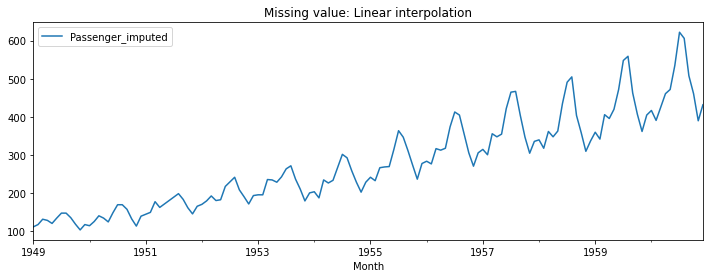

In [49]:
#handling null values
y_hat_sma = y_hat_sma.assign(Passenger_imputed = y_hat_sma.Passengers.interpolate(method='linear'))
y_hat_sma[['Passenger_imputed']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Linear interpolation')
plt.show(block=False)

In [50]:
y_hat_sma['Passengers'] = y_hat_sma['Passenger_imputed']

In [51]:
y_hat_sma['Passengers'].isnull().sum()

0

In [52]:
ma_window = 12
y_hat_sma['sma_forecast'] = y_hat_sma['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

#### Plotting train test and forecast

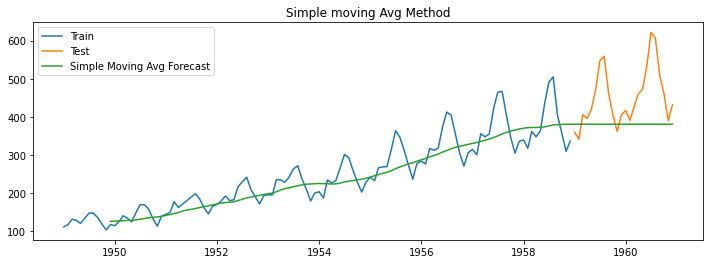

In [53]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_sma['sma_forecast'], label = 'Simple Moving Avg Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple moving Avg Method')
plt.show()

#### rmse and mape

In [54]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['SMA method12'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33


sma=6

In [55]:
ma_window = 6
y_hat_sma['sma_forecast'] = y_hat_sma['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

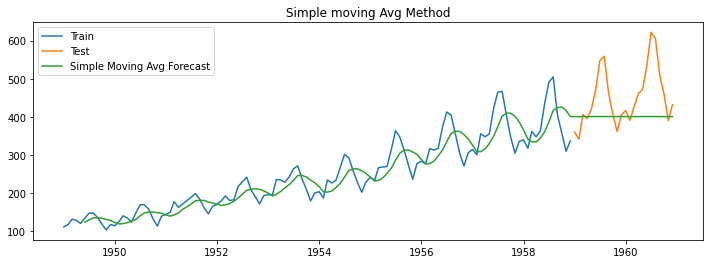

In [56]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_sma['sma_forecast'], label = 'Simple Moving Avg Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple moving Avg Method')
plt.show()

In [57]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['SMA method6'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33
0,SMA method6,12.97,90.64


sma=3

In [58]:
ma_window = 3
y_hat_sma['sma_forecast'] = y_hat_sma['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

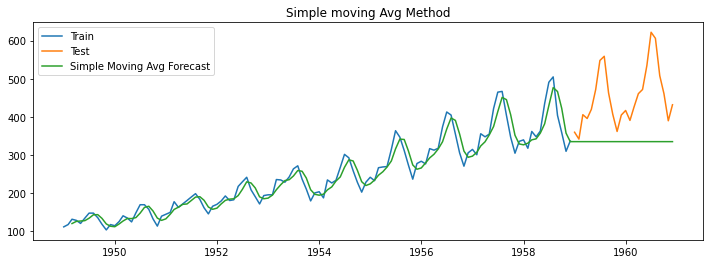

In [59]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_sma['sma_forecast'], label = 'Simple Moving Avg Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple moving Avg Method')
plt.show()

In [60]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['SMA method3'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33
0,SMA method6,12.97,90.64
0,SMA method3,24.01,138.91


#### Simple Exponential Smoothing

In [61]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing as ses
model = ses(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2, optimized=False)
print(model_fit.params)
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24) #24months

{'smoothing_level': 0.2, 'smoothing_trend': None, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 112.0, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Plotting train test forecast

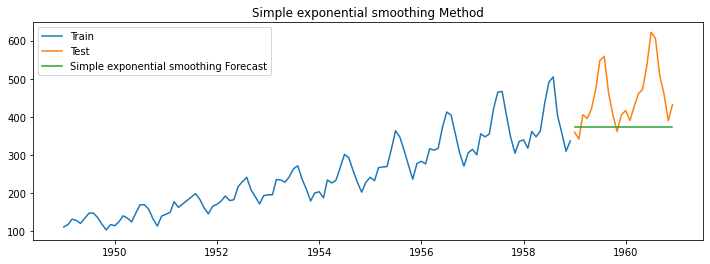

In [62]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_ses['ses_forecast'], label = 'Simple exponential smoothing Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple exponential smoothing Method')
plt.show()

#### RMSE MAPE

In [63]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['SES0.2'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33
0,SMA method6,12.97,90.64
0,SMA method3,24.01,138.91
0,SES0.2,16.49,107.65


alpha=0.4

In [64]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing as ses
model = ses(train['Passengers'])
model_fit = model.fit(smoothing_level=0.4, optimized=False)
print(model_fit.params)
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24) #24months

{'smoothing_level': 0.4, 'smoothing_trend': None, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 112.0, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


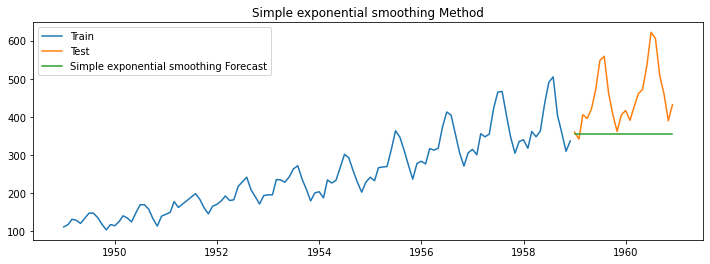

In [65]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_ses['ses_forecast'], label = 'Simple exponential smoothing Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple exponential smoothing Method')
plt.show()

In [66]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['SES0.4'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33
0,SMA method6,12.97,90.64
0,SMA method3,24.01,138.91
0,SES0.2,16.49,107.65
0,SES0.4,19.82,122.57


alpha=0.8

In [67]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing as ses
model = ses(train['Passengers'])
model_fit = model.fit(smoothing_level=0.8, optimized=False)
print(model_fit.params)
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24) #24months

{'smoothing_level': 0.8, 'smoothing_trend': None, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 112.0, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


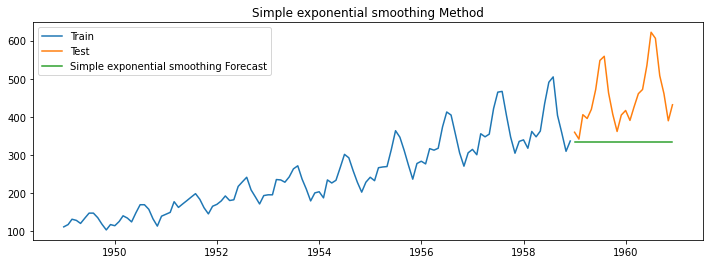

In [68]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_ses['ses_forecast'], label = 'Simple exponential smoothing Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple exponential smoothing Method')
plt.show()

In [69]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['SES0.8'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33
0,SMA method6,12.97,90.64
0,SMA method3,24.01,138.91
0,SES0.2,16.49,107.65
0,SES0.4,19.82,122.57
0,SES0.8,24.30,139.98


#### Holt's exponential smoothing

In [70]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as es
model = es(np.asarray(train['Passengers']), seasonal_periods=12, trend='additive', seasonal=None) #we have to pass it as an array 
#even though seasonal_period is mentioned, holt's es does not capture it
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 112.0, 'initial_trend': 6.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


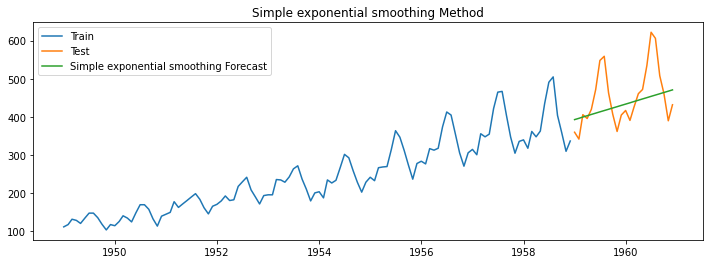

In [71]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_holt['holt_forecast'], label = 'Simple exponential smoothing Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple exponential smoothing Method')
plt.show()

In [72]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['HOLT 0.2 0.01'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33
0,SMA method6,12.97,90.64
0,SMA method3,24.01,138.91
0,SES0.2,16.49,107.65
0,SES0.4,19.82,122.57
0,SES0.8,24.30,139.98
0,HOLT 0.2 0.01,11.11,71.94


0.2 0.1

In [73]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as es
model = es(np.asarray(train['Passengers']), seasonal_periods=12, trend='additive', seasonal=None) #we have to pass it as an array 
#even though seasonal_period is mentioned, holt's es does not capture it
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.1, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2, 'smoothing_trend': 0.1, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 112.0, 'initial_trend': 6.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


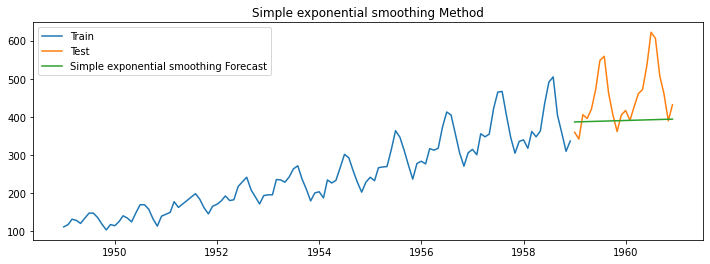

In [74]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_holt['holt_forecast'], label = 'Simple exponential smoothing Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple exponential smoothing Method')
plt.show()

In [75]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['HOLT 0.2 0.1'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33
0,SMA method6,12.97,90.64
0,SMA method3,24.01,138.91
0,SES0.2,16.49,107.65
0,SES0.4,19.82,122.57
0,SES0.8,24.30,139.98
0,HOLT 0.2 0.01,11.11,71.94
0,HOLT 0.2 0.1,13.98,96.29


0.2 0.001

In [76]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as es
model = es(np.asarray(train['Passengers']), seasonal_periods=12, trend='additive', seasonal=None) #we have to pass it as an array 
#even though seasonal_period is mentioned, holt's es does not capture it
model_fit = model.fit(optimized=True) #smoothing_level=0.2, smoothing_slope=0.001, 
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.9934512310535834, 'smoothing_trend': 0.0009054319520518981, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 111.94606519535795, 'initial_trend': 1.5215083622324377, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


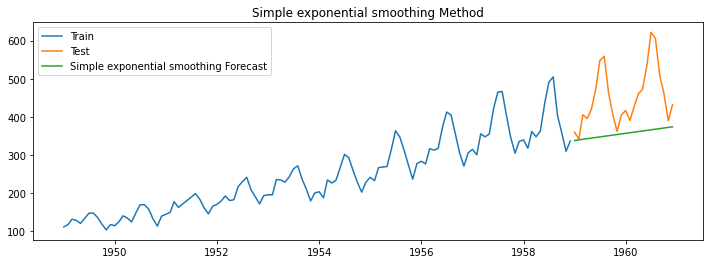

In [77]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_holt['holt_forecast'], label = 'Simple exponential smoothing Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple exponential smoothing Method')
plt.show()

In [78]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['HOLT 0.2 0.001'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33
0,SMA method6,12.97,90.64
0,SMA method3,24.01,138.91
0,SES0.2,16.49,107.65
0,SES0.4,19.82,122.57
0,SES0.8,24.30,139.98
0,HOLT 0.2 0.01,11.11,71.94
0,HOLT 0.2 0.1,13.98,96.29


#### Holt winter's additive method with trend and seasonality

In [79]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as es
model = es(np.asarray(train['Passengers']), seasonal_periods=12, trend='add', seasonal='add') 
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa = test.copy()
y_hat_hwa['hwa_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.23615815135772011, 'smoothing_trend': 0.0, 'smoothing_seasonal': 0.7638418486422799, 'damping_trend': nan, 'initial_level': 204.98775010890893, 'initial_trend': 2.277125578879114, 'initial_seasons': array([ -95.26477839,  -89.72946402,  -77.22895316,  -82.34755114,
        -91.04048136,  -76.87513463,  -64.61027726,  -66.56007629,
        -80.69101219,  -99.57005515, -114.23801844,  -98.02808547]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


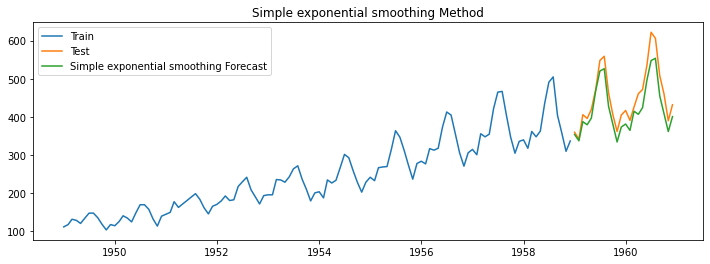

In [80]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_hwa['hwa_forecast'], label = 'Simple exponential smoothing Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple exponential smoothing Method')
plt.show()

In [81]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hwa_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_hwa['hwa_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['HOLT winters add'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33
0,SMA method6,12.97,90.64
0,SMA method3,24.01,138.91
0,SES0.2,16.49,107.65
0,SES0.4,19.82,122.57
0,SES0.8,24.30,139.98
0,HOLT 0.2 0.01,11.11,71.94
0,HOLT 0.2 0.1,13.98,96.29


#### Holt winter's multiplicative method with trend and seasonality

In [82]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as es
model = es(np.asarray(train['Passengers']), seasonal_periods=12, trend='add', seasonal='mul') 
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm = test.copy()
y_hat_hwm['hwm_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.3655865614456789, 'smoothing_trend': 8.003382780364158e-08, 'smoothing_seasonal': 0.6344134168549864, 'damping_trend': nan, 'initial_level': 182.90595507171616, 'initial_trend': 3.9608579040286487, 'initial_seasons': array([0.59936353, 0.63043657, 0.69295765, 0.65877107, 0.60804705,
       0.664941  , 0.72308922, 0.71817668, 0.65513481, 0.57089973,
       0.50755226, 0.58555887]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


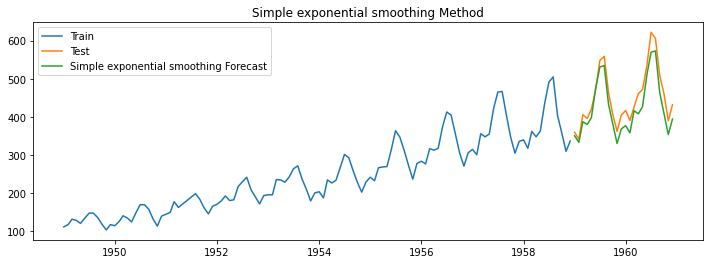

In [83]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_hwm['hwm_forecast'], label = 'Simple exponential smoothing Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Simple exponential smoothing Method')
plt.show()

In [84]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hwm_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_hwm['hwm_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : ['HOLT winters mul'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple avg method,44.28,219.69
0,SMA method12,15.54,103.33
0,SMA method6,12.97,90.64
0,SMA method3,24.01,138.91
0,SES0.2,16.49,107.65
0,SES0.4,19.82,122.57
0,SES0.8,24.30,139.98
0,HOLT 0.2 0.01,11.11,71.94
0,HOLT 0.2 0.1,13.98,96.29


### Auto Regressive models

#### Stationary vs non-stationary time series

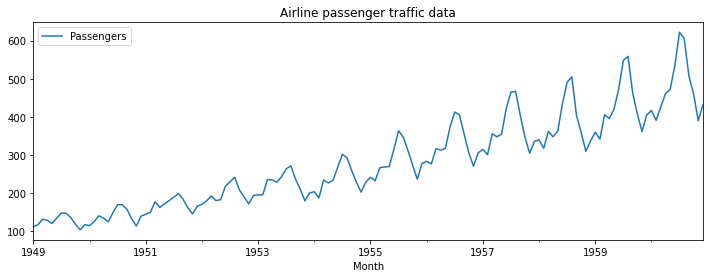

In [6]:
df['Passengers'].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline passenger traffic data')
plt.show()

#### Augmented Dickey Fuller test (ADF)

In [7]:
from statsmodels.tsa.stattools import adfuller as adf
adf_test = adf(df['Passengers'])
print('ADF statistics: %f' %adf_test[0])
print('Critical value @ 0.05: %.2f' %adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF statistics: 0.894609
Critical value @ 0.05: -2.88
p-value: 0.993020


We fail to reject null hypothesis and it is not a stationary series since adf statistic is higher than critical value.

#### KPSS test

In [8]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(df['Passengers'])
print('KPSS statistic: %f' % kpss_test[0])
print('Critical value @ 0.05:  %.2f' %kpss_test[3]['5%']) 
print('p-value: %f' %kpss_test[1])

KPSS statistic: 1.052050
Critical value @ 0.05:  0.46
p-value: 0.010000


C:\Users\getch\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The series is not stationary and we reject null hypothesis since kpss statistic is higher than critical value.

### Box cox transformation

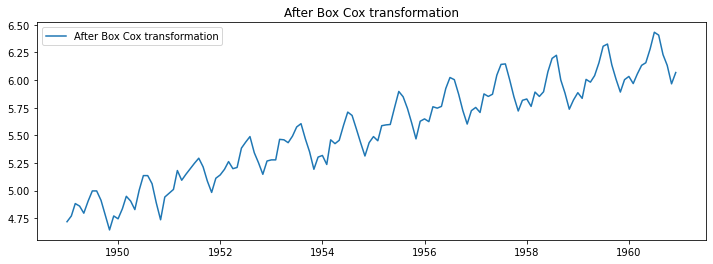

In [9]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(df['Passengers'], lmbda=0), index = df.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox transformation')
plt.legend(loc='best')
plt.title('After Box Cox transformation')
plt.show()

### Differencing

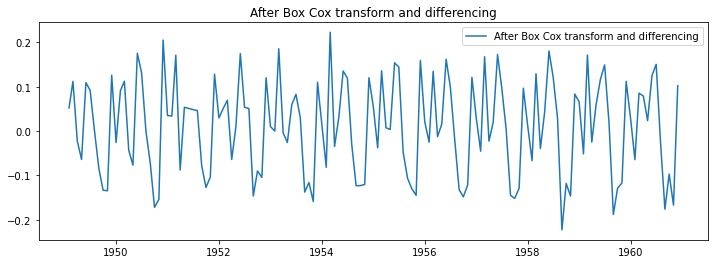

In [10]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index = df.index)
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox transform and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

#### ADF test

In [11]:
# from statsmodels.tsa.stattools import adfuller as adf
adf_test = adf(data_boxcox_diff)
print('ADF statistics: %f' %adf_test[0])
print('Critical value @ 0.05: %.2f' %adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF statistics: -3.290114
Critical value @ 0.05: -2.88
p-value: 0.015326


It is stationary as ADF statistic is lower than critical value and hence rejecting null hypothesis (check)

#### KPSS test

In [12]:
# from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data_boxcox_diff)
print('KPSS statistic: %f' % kpss_test[0])
print('Critical value @ 0.05:  %.2f' %kpss_test[3]['5%']) 
print('p-value: %f' %kpss_test[1])

KPSS statistic: 0.101871
Critical value @ 0.05:  0.46
p-value: 0.100000


C:\Users\getch\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Hence Stationary

#### Auto correlation function (ACF) plot

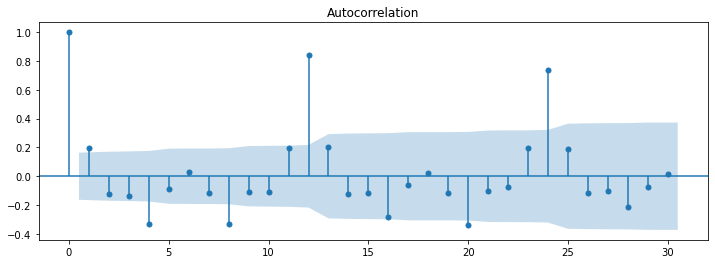

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

#### Partial auto correlation plot (PACF)

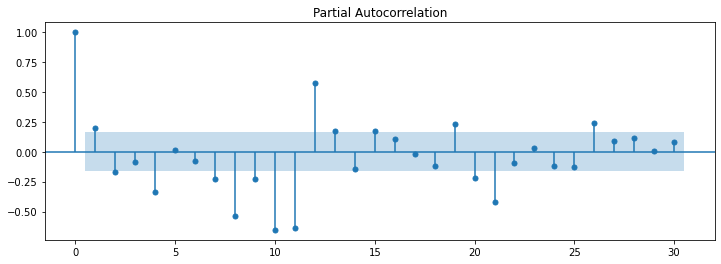

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

### AR models

#### Simple AR model

#### Split into training and test data sets

In [15]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [16]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1,0,0))
model_fit = model.fit()
print(model_fit.params)

const      0.009477
ar.L1.y    0.183116
dtype: float64


C:\Users\getch\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Recover original time series forecast

In [17]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

#### Plot train test and forecast data

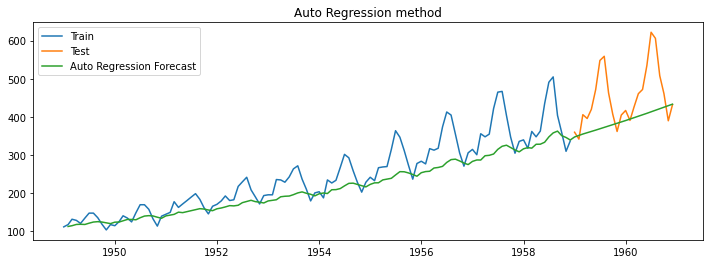

In [18]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_ar['ar_forecast'], label = 'Auto Regression Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('Auto Regression method')
plt.show()

#### MAPE and RMSE

In [21]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ar['ar_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_ar['ar_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : 'Auto Regressive method', 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results = results(['Method','MAPE','RMSE'])
results

ValueError: Found input variables with inconsistent numbers of samples: [24, 143]

#### Moving average method

In [22]:
model = ARIMA(train_data_boxcox_diff, order=(0,0,1))
model_fit = model.fit()
print(model_fit.params)

C:\Users\getch\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      0.009538
ma.L1.y    0.266103
dtype: float64


#### Recover original time series forecast

In [23]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

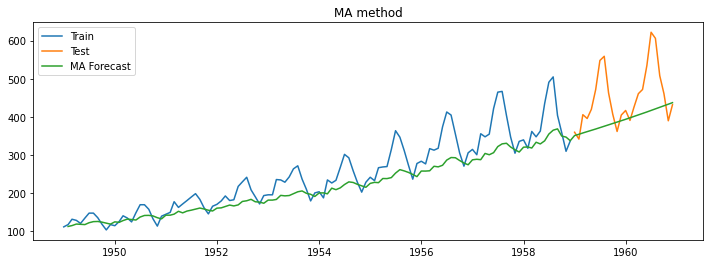

In [24]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(y_hat_ma['ma_forecast'], label = 'MA Forecast')
plt.legend(loc='best') #to set legend in right place
plt.title('MA method')
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ma['ma_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_ma['ma_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method' : 'MA method', 'MAPE' : [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results = results(['Method','MAPE','RMSE'])
results

ValueError: Found input variables with inconsistent numbers of samples: [24, 143]